## DenseNet ##

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
## Necessary imports
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
#from keras.datasets import mnist
#from keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import random
import os
#import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras import layers

from os import path, listdir

import tensorflow as tf

In [3]:
# Hyperparameters
#batch_size = 2608
img_height = 256
img_width = 256

#batch_size = 2048
batch_size = 63424



In [4]:
# Directories
#/data/projects/beemachine
dir = "../dataset_2/training"
#dir = "/homes/okerinde/projects/beemachine/dataset_3/training"

### Process Dataset ###

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 79280 files belonging to 24 classes.
Using 63424 files for training.


2021-12-17 08:39:56.730266: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-17 08:39:56.730352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 424637012a3e
2021-12-17 08:39:56.730371: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 424637012a3e
2021-12-17 08:39:56.730516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.44.0
2021-12-17 08:39:56.730563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.44.0
2021-12-17 08:39:56.730577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.44.0
2021-12-17 08:39:56.731770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 79280 files belonging to 24 classes.
Using 15856 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)
image_batches_val = []
labels_batches_val = []

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch_val, labels_batch_val in val_ds:
  image_batches_val.append(image_batch_val)
  labels_batches_val.append(labels_batch_val)
  print(image_batch_val.shape)
  print(labels_batch_val.shape)
  #break



['Bombus_affinis', 'Bombus_auricomus', 'Bombus_bifarius', 'Bombus_bimaculatus', 'Bombus_borealis', 'Bombus_centralis', 'Bombus_citrinus', 'Bombus_fernaldae_flavidus', 'Bombus_fervidus_californicus', 'Bombus_flavifrons', 'Bombus_griseocollis', 'Bombus_huntii', 'Bombus_impatiens', 'Bombus_insularis', 'Bombus_melanopygus', 'Bombus_mixtus', 'Bombus_nevadensis', 'Bombus_pensylvanicus_sonorus', 'Bombus_perplexus', 'Bombus_rufocinctus', 'Bombus_ternarius', 'Bombus_terricola', 'Bombus_vagans', 'Bombus_vosnesenskii']


2021-12-17 08:40:01.133593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-17 08:40:11.134369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 10210 of 507392
2021-12-17 08:40:21.140959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18813 of 507392
2021-12-17 08:40:31.134506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 25982 of 507392
2021-12-17 08:40:41.133412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 32727 of 507392
2021-12-17 08:40:51.138800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 39075 of 507392
2021-12-17 08:41:01.137500: I tensorflow/core/kernels/data/shuffle_dataset_op.c

(63424, 256, 256, 3)
(63424,)


2021-12-17 08:42:33.779950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 10196 of 507392
2021-12-17 08:42:40.063452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


(15856, 256, 256, 3)
(15856,)


In [8]:
def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1

    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1.0)

            # create negative pair
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0.0)

    return np.array(pairs), np.array(labels)

In [9]:
pairs_train, labels_train = create_pairs(image_batch, labels_batch, len(class_names))

pairs_val, labels_val = create_pairs(image_batches_val[-1], labels_batches_val[-1], len(class_names))

#pairs_train[2,0]
#labels_train[0]

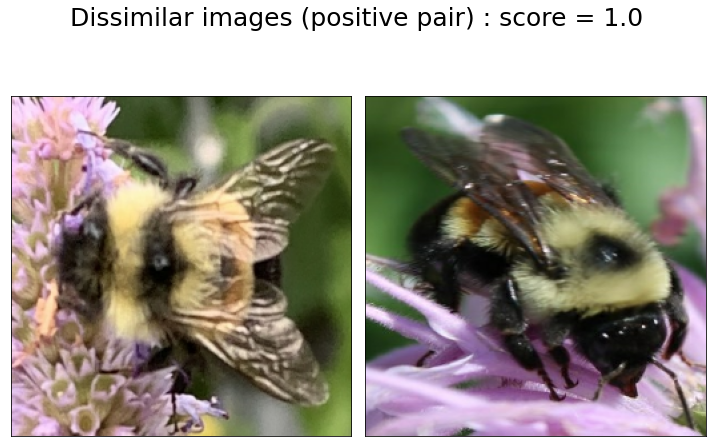

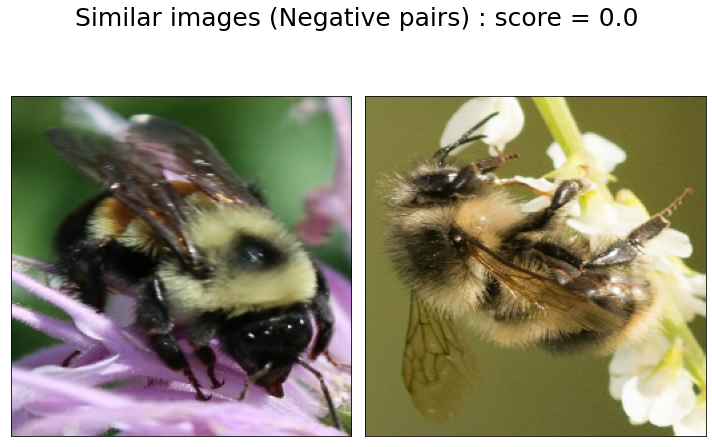

In [10]:
###Let us see the image pairs ###

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(pairs_train[0, 0].astype('uint8'))
ax2.imshow(pairs_train[0, 1].astype('uint8'))

for ax in [ax1, ax2]:
 ax.grid(False)
 ax.set_xticks([])
 ax.set_yticks([])

fig.suptitle(f"Dissimilar images (positive pair) : score = {labels_train[0]}", size=25)
plt.tight_layout()
plt.show()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(pairs_train[3, 0].astype('uint8'))
ax2.imshow(pairs_train[3, 1].astype('uint8'))

for ax in [ax1, ax2]:
 ax.grid(False)
 ax.set_xticks([])
 ax.set_yticks([])

fig.suptitle(f"Similar images (Negative pairs) : score = {labels_train[3]}", size=25)
plt.tight_layout()
plt.show()


In [11]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean(Y_true*K.square(D)+(1 - Y_true)*K.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))



def create_shared_network(input_shape):
    model = Sequential(name='Shared_Conv_Network')
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model


In [12]:
num_classes = len(train_ds.class_names)

In [13]:
def create_shared_network_2(input_shape):
  model = Sequential([
                      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.BatchNormalization(),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.BatchNormalization(),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, 3, padding='same', activation='relu'),
                      layers.BatchNormalization(),
                      layers.MaxPooling2D(),
                      layers.Flatten(),
                      #layers.Dense(128, activation='relu'),
                      layers.Dense(128, activation='sigmoid')

  ])

  return model

In [14]:
def create_shared_network_3(input_shape):
  model = Sequential([
                      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                      layers.Conv2D(16, 3, padding='same'),
                     # layers.BatchNormalization(),
                      layers.ReLU(),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same'),
                     # layers.BatchNormalization(),
                      layers.ReLU(),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, 3, padding='same'),
                     # layers.BatchNormalization(),
                      layers.ReLU(),
                      layers.MaxPooling2D(),
                      layers.Flatten(),
                      #layers.Dense(128, activation='relu'),
                      layers.Dense(128, activation='sigmoid')

  ])

  return model

In [15]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
def create_shared_network_fe(img_height):

        # Create the base model from the pre-trained model MobileNet V2
        IMG_SHAPE = (256, 256) + (3,)
        base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

        base_model.trainable = False

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        #feature_batch_average = global_average_layer(feature_batch)
        #print(feature_batch_average.shape)

        inputs = tf.keras.Input(shape=(256, 256, 3))
        x = data_augmentation(inputs)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        #x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = layers.Conv2D(16, 3, padding='same')(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(32, 3, padding='same')(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(128, activation='sigmoid')(x)
        model = tf.keras.Model(inputs, outputs)

        return model

In [17]:
def create_shared_network_4(input_shape):
  model = Sequential([
                      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                      layers.Conv2D(16, 3, padding='same'),
                     # layers.BatchNormalization(),
                      layers.ReLU(),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same'),
                     # layers.BatchNormalization(),
                      layers.ReLU(),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, 3, padding='same'),
                     # layers.BatchNormalization(),
                      layers.ReLU(),
                      layers.MaxPooling2D(),
                      layers.Flatten(),
                      #layers.Dense(128, activation='relu'),
                      layers.Dense(128, activation='sigmoid')

  ])

  return model



## Build the model ##

In [18]:
'''
Main code for training a Siamese neural network for face recognition
'''
# import utils
import numpy as np
from keras.layers import Input, Lambda
from keras.models import Model

# Import Training and Testing Data
X_train = image_batch
Y_train = labels_batch
X_val = image_batch_val
Y_val = labels_batch_val
num_classes = len(np.unique(Y_train))
print(f'num_classes: {num_classes}')

# Create Siamese Neural Network
input_shape = X_train.shape[1:]
shared_network = create_shared_network_fe(input_shape)
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])
model = Model(inputs=[input_top, input_bottom], outputs=distance)

# Train the model
training_pairs, training_labels = create_pairs(X_train, Y_train,
                                num_classes=num_classes)


val_pairs, val_labels = create_pairs(X_val, Y_val,
                                num_classes=num_classes)


callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
model.compile(loss=contrastive_loss, optimizer='adam',
              metrics=[accuracy])

print(model.summary())



num_classes: 24
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          7216432     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]

## Train the model ##

In [19]:
#plot the model
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='siamese_network_plot.png', show_shapes=True, show_layer_names=True)


# Save checkpoints during training
checkpoint_path = '../checkpoint_siamese_nn_fe_densenet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Restore from checkpoint if one exists
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest:
   print('Restoring model from checkpoint')
   model.load_weights(latest)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_path,
save_weights_only=True,
monitor='val_loss',
mode='min',
save_best_only=True)

history = model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels,
          batch_size=64,
          callbacks=[callback,cp_callback],
          epochs=1,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels))



Restoring model from checkpoint
492/492 [==============================] - 2440s 5s/step - loss: 0.3248 - accuracy: 0.6237 - val_loss: 0.3221 - val_accuracy: 0.6341


## Evaluate the trained model ##

In [20]:
predictions = model.predict_on_batch([val_pairs[:, 0][2000:4000], val_pairs[:, 1][2000:4000]])
print('predictions', predictions)
y_pred = np.array([1.0 if x < 0.5 else 0.0 for x in predictions])

print('y_pred', y_pred)
y_true = val_labels[2000:4000]

predictions [[0.18581939]
 [0.2463134 ]
 [0.26407406]
 ...
 [0.36616325]
 [0.5378606 ]
 [0.95698076]]
y_pred [1. 1. 1. ... 1. 0. 0.]


In [21]:
print('y_true', y_true)
print(tf.math.confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


y_true [1. 0. 1. ... 0. 1. 0.]
tf.Tensor(
[[569 431]
 [320 680]], shape=(2, 2), dtype=int32)
              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60      1000
         1.0       0.61      0.68      0.64      1000

    accuracy                           0.62      2000
   macro avg       0.63      0.62      0.62      2000
weighted avg       0.63      0.62      0.62      2000



## Save the model ## 

In [22]:
import time
time_saved = time.time()
#model.save('siamese_nn_trained_{}.h5'.format(time_saved))
print(f'time_saved : {time_saved}')

time_saved : 1639754834.2711394


## Visualizing the performance statistics ##

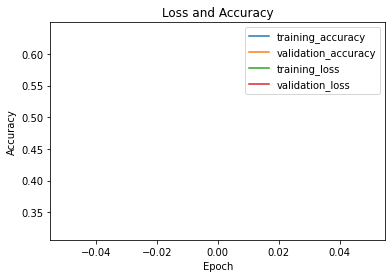

In [23]:
#import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Loss and Accuracy')
plt.legend()
plt.savefig('plt_fe_densenet.png', dpi=300, bbox_inches='tight')
# Save the model
#model.save('siamese_nn_trained_on_63424_5epochs.h5')

In [24]:
# Validate the model
model.evaluate([val_pairs[:,0], val_pairs[:, 1]], val_labels)

270/270 [==============================] - 454s 2s/step - loss: 0.3221 - accuracy: 0.6341


[0.32208287715911865, 0.6341435313224792]